## NB1: The multispecies coalescent in space and time

Code to generate data and plots for Figure 2. The entire notebook takes about 1 hour to run on an 8 core laptop with 16Gb RAM. 

In [1]:
# conda create -n ipcoal python=3.7
# conda activate ipcoal
# conda install ipcoal -c conda-forge -c bioconda

In [ ]:
import ipcoal
import toytree
import toyplot, toyplot.pdf, toyplot.svg
import numpy as np
import pandas as pd
import time
import os

In [2]:
# parallel processing Py3
from concurrent.futures import ProcessPoolExecutor

In [4]:
# print versions of our libraries 
print('toytree', toytree.__version__)
print('ipcoal', ipcoal.__version__)

toytree 1.1.2
ipcoal 0.1.0


In [5]:
# make a subdirectory for storing some working files
WORKDIR = "results"
os.makedirs(WORKDIR, exist_ok=True)

### Function to simulate genealogies
This will be used to explore the effect of Ne, r, height, ntips on genealogical patterns distributed spatially across a genome. 

In [6]:
def sim_imb_fixed_t(ntips, height, nloci, nsites, coal, seed=123):
    """
    Return an ipcoal.Model object with genealogies simulated
    for 'nloci' and 'nsites' on an imbalanced 'tree' with Ne auto
    scaled so that all internal edges are 'coal' units long. 
    """
    # generate imbalanced tree
    tree = toytree.rtree.imbtree(ntips=ntips)
    
    # scale stem height 
    tree = tree.mod.node_scale_root_height(treeheight=height, include_stem=True)
    
    # get internode dist
    dist = tree.treenode.dist
    
    # get Ne by scaling coalunits by internode height
    Ne = dist / (coal * 2.)
    
    # init model and sim n unlinked genealogies
    model = ipcoal.Model(tree, Ne=Ne, seed=seed)
    model.sim_trees(nloci=nloci, nsites=nsites)
    return model.df

### Function to get pairwise RF distances among genealogies

In [92]:
def get_unlinked_RFs(table, subsample=False, normalize=False, seed=123):
    """
    Returns RF dist between N unlinked genealogies in a dataframe returned
    by ipcoal.Model().df. Normalize returns the RF / RFmax distance.
    """
    # seed
    np.random.seed(seed)
    
    # if subsample then 
    if subsample:
        if int(subsample) <= table.shape[0]:
            table = table.sample(int(subsample))
        
    # load genealogies as toytrees and init empty arr
    mtre = [toytree._rawtree(i) for i in table.genealogy.tolist()]
    ntrees = len(mtre)
    rfs = []
    
    # iter to compare all pairwise lower triangle
    for idx in range(ntrees):
        for jdx in range(ntrees):
            if idx < jdx:
                
                # get rf distance
                t0 = mtre[idx].treenode
                t1 = mtre[jdx].treenode
                
                if normalize:
                    rf, rfmax = t0.robinson_foulds(t1)[:2]
                    rf = rf / rfmax
                else:
                    rf = t0.robinson_foulds(t1)[0]

                # store result
                rfs.append(rf)
                
    # return as an array
    return np.array(rfs)

## Species tree parameters 

In [8]:
coalunits = [0.2, 1.0, 2.0]
treesizes = [10, 50, 100]
treeheights = [100000, 1000000, 10000000]

## Unlinked genealogies

#### Distribute simulation jobs

Tree height has no effect here so we do not iterate over it.

In [9]:
sample_size = 1000

In [22]:
# to be filled with {jobname: ipcoal.Model().df} DataFrame results
results1 = {}
    
# distribute parallel jobs
with ProcessPoolExecutor(max_workers=40) as executor:
    
    # iterate over internode lengths in coal units
    for coal in coalunits:
        
        # iterate over tree sizes in ntips
        for ntips in treesizes:
            
            # iterate over tree-heights even though they have NO EFFECT
            for th in treeheights:

                # jobname 
                jobname = "tree-{}-coal-{}-th-{}".format(ntips, coal, th)

                # args: ntips, height, nloci, nsites, coal, seed
                args = (ntips, int(th), sample_size, 1, coal, 123)
                
                # this will calculate Ne and run simulation
                future = executor.submit(sim_imb_fixed_t, *args)

                # store future
                results1[jobname] = future

#### Distribute RF calculation jobs
This measure the RF distance between unlinked genealogies to get a baseline estimate to compare against when measuring linkage. 500 genealogies seems to give a good approximation of the mean RF.

In [109]:
# to be filled with {jobname: np.ndarray} RF results
results2 = {}
   
# distribute parallel jobs
with ProcessPoolExecutor(max_workers=40) as executor:
    
    # iterate over parameter settings 
    for ntips in treesizes:
        for coal in coalunits:
            for th in treeheights:

                # get simulation results
                jobname = "tree-{}-coal-{}-th-{}".format(ntips, coal, th)
                table = results1[jobname].result()

                # get RF distances, args=(table, subsample, seed)
                args = (table, sample_size, True, 123)
                future = executor.submit(get_unlinked_RFs, *args)
                results2[jobname] = future

#### Enter results into the `resdf` table

In [14]:
# table1 = pd.DataFrame({
#     "ntips": np.repeat(treesizes, len(coalunits) * len(treeheights)),
#     "tc": np.tile(np.repeat(coalunits, len(treesizes)), len(treeheights)),
#     "tg": np.tile(np.tile(treeheights, len(coalunits)), len(treesizes)).astype(int),
#     "block-size": "",
#     "unlinked-RF": 0.,
#     "linked-RF-10K": 0.,
#     "linked-RF-100K": 0.,
# })

In [118]:
resdf = pd.DataFrame({
    "ntips": np.repeat(treesizes, len(coalunits) * len(treeheights)),
    "tc": np.tile(np.repeat(coalunits, len(treesizes)), len(treeheights)),
    "height": np.tile(np.tile(treeheights, len(coalunits)), len(treesizes)).astype(int),
    "uRF-mean": 0.,
    "uRF-std": 0.,
    "block-size": 0,
})

In [119]:
# iterate over parameter settings to enter results
for ntips in treesizes:
    for coal in coalunits:
        for th in treeheights:

            # get simulation results
            jobname = "tree-{}-coal-{}-th-{}".format(ntips, coal, th)
            rfs = results2[jobname].result()

            # get mask to fill cell for this specific job
            m1 = resdf.tc == coal
            m2 = resdf.height == th
            m3 = resdf.ntips == ntips
            mask = m1 & m2 & m3

            # fill the table with values from off diagonal
            resdf.loc[mask, "uRF-mean"] = rfs.mean()
            resdf.loc[mask, "uRF-std"] = rfs.std()


In [120]:
# add tg column as length of internodes
resdf["tg"] = (resdf["height"] / resdf["ntips"]).astype(int)
resdf

,ntips,tc,height,uRF-mean,uRF-std,block-size,tg
0,10,0.2,100000,0.404621,0.051423,0,10000
1,10,0.2,1000000,0.404668,0.051378,0,100000
2,10,0.2,10000000,0.404691,0.051336,0,1000000
3,10,1.0,100000,0.215834,0.087865,0,10000
4,10,1.0,1000000,0.216043,0.087829,0,100000
5,10,1.0,10000000,0.215262,0.087997,0,1000000
6,10,2.0,100000,0.079571,0.063862,0,10000
7,10,2.0,1000000,0.079470,0.064030,0,100000
8,10,2.0,10000000,0.079284,0.063655,0,1000000
9,50,0.2,100000,0.466602,0.017514,0,2000


### Plot unlinked results
The average RF distance between any two unlinked genealogies in a genome increases with the size of the tree, and it increases faster if the internode lengths are shorter in coalescent units, meaning there is higher probability of incongruence. This all makes sense with the classic MSC model. 

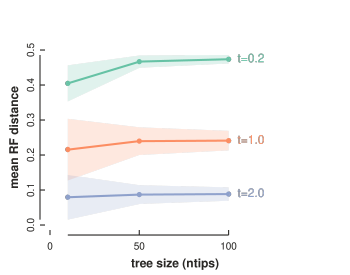

In [123]:
toyplot.config.autoformat = "html"

# get canvas and axes
canvas = toyplot.Canvas(width=350, height=275);
axes = canvas.cartesian(
    xlabel="tree size (ntips)", 
    ylabel="mean RF distance",
)
axes.x.ticks.show = True
axes.y.ticks.show = True
axes.x.domain.max = 140
axes.x.ticks.locator = toyplot.locator.Explicit((0, 50, 100))

# plot the data markers
for coal in resdf.tc.unique():
    
    # subselect data
    mask = resdf["tc"] == coal
    
    # draw the mean measured points   
    axes.scatterplot(
        resdf.loc[mask, "ntips"], 
        resdf.loc[mask, "uRF-mean"],
    )
    
    # draw the mean connecting lines
    axes.plot(
        resdf.loc[mask, "ntips"], 
        resdf.loc[mask, "uRF-mean"],
    )
    
    # fill a shade to the +-std
    axes.fill(
        resdf.loc[mask, "ntips"], 
        resdf.loc[mask, "uRF-mean"] - resdf.loc[mask, "uRF-std"],
        resdf.loc[mask, "uRF-mean"] + resdf.loc[mask, "uRF-std"],
        opacity=0.2,
    )
    
    # add labels
    axes.text(
        resdf.loc[mask, "ntips"].max() + 5, 
        resdf.loc[mask, "uRF-mean"].max(), 
        "t={}".format(coal),
        style={"text-anchor": "start"},
    )
    
#toyplot.svg.render(canvas, "../manuscript/figures/Table-1-plot-unlinked.svg")
#toyplot.pdf.render(canvas, "../manuscript/figures/Table-1-plot-unlinked.pdf")
canvas

## Linked genealogies

In [126]:
def get_linked_RFs(table, niter, normalize=False, seed=123):
    """
    Returns a dataframe with mean and std of RF distances
    between niter sampled genealogies separated by genetic
    distances on a chromosome that are log10 spaced. 
    """
    # seed
    np.random.seed(seed)
    
    # sample log10 spaced points between 0-500Kb
    dmax = np.log10(table.end.max() * 0.5)
    dists =  np.logspace(0.25, dmax, 50, dtype=int)
    df = pd.DataFrame({
        "dists": dists,
        "lRF-mean": 0.,
        "lRF-std": 0,
    })
    
    # iterate over distances and randomly sample niter trees
    for dx in df.index:
        dist = df.dists[dx]
        vals = []
        starts = np.random.uniform(0, table.end.max(), niter)
        for idx in range(niter):
            start = starts[idx]
            
            # get sampling locations dist apart
            if not start + dist > table.end.max():
                locs = (start, start + dist)
            else:
                locs = (start - dist, start)
            
            # get trees at locs
            mask1 = table.start <= locs[1]
            mask2 = table.end > locs[0]
            trees = table.loc[mask1 & mask2]
            t0 = trees.iloc[0, -1]
            t1 = trees.iloc[-1, -1]
            t0 = toytree._rawtree(t0).treenode
            t1 = toytree._rawtree(t1).treenode
            
            # get RF and store it
            if normalize:
                rf, rfmax = t0.robinson_foulds(t1)[:2]
                rf = rf / rfmax
            else:
                rf = t0.robinson_foulds(t1)[0]
            vals.append(rf)
        
        # store to dataframe 
        df.loc[dx, "lRF-mean"] = np.mean(vals)
        df.loc[dx, "lRF-std"] = np.std(vals)
        
    return df

#### Distribute simulation jobs

In [127]:
# to be filled with {jobname: pd.DataFrame} results
results3 = {}
    
# distribute parallel jobs
with ProcessPoolExecutor(max_workers=40) as executor:

    # iterate over treeheights
    for th in treeheights:

        # iterate over internode lengths in coal units
        for coal in coalunits:

            # iterate over tree sizes in ntips
            for ntips in treesizes:

                # jobname 
                jobname = "tree-{}-coal-{}-th-{}".format(ntips, coal, th)

                # args: ntips, height, nloci, nsites, coal, seed
                args = (ntips, th, 1, 1e6, coal, 123)
                future = executor.submit(sim_imb_fixed_t, *args)

                # store future
                results3[jobname] = future

In [128]:
# save results to CSV
for jobname, future in results3.items():
    table = future.result()
    table.to_csv(os.path.join(WORKDIR, jobname + ".csv"))

In [129]:
# new info to store to results dataframe (Table 1)
resdf["block-mean"] = 0.
resdf["block-std"] = 0.

# iterate over parameter settings to enter results
for ntips in treesizes:
    for coal in coalunits:
        for th in treeheights:

            # get simulation results
            jobname = "tree-{}-coal-{}-th-{}".format(ntips, coal, th)
            rfs = results3[jobname].result()

            # get mask to fill cell for this specific job
            m1 = resdf.tc == coal
            m2 = resdf.height == th
            m3 = resdf.ntips == ntips
            mask = m1 & m2 & m3

            # fill the table with values from off diagonal
            resdf.loc[mask, "block-mean"] = rfs.nbps.mean()
            resdf.loc[mask, "block-std"] = rfs.nbps.std()

In [135]:
# add Ne to the table
resdf["Ne"] = (resdf.tg / (resdf.tc * 2.)).astype(int)

In [136]:
resdf.to_csv(os.path.join(WORKDIR, "Table-1-blocks.csv"))
resdf[resdf.ntips == 50].round(2)

,ntips,tc,height,uRF-mean,uRF-std,block-size,tg,block-mean,block-std,Ne
9,50,0.2,100000,0.47,0.02,0,2000,1485.88,1458.36,5000
10,50,0.2,1000000,0.47,0.02,0,20000,149.97,146.60,50000
11,50,0.2,10000000,0.47,0.02,0,200000,15.01,14.53,500000
12,50,1.0,100000,0.24,0.04,0,2000,4830.92,4603.76,1000
13,50,1.0,1000000,0.24,0.04,0,20000,509.42,511.64,10000
14,50,1.0,10000000,0.24,0.04,0,200000,51.67,50.97,100000
15,50,2.0,100000,0.09,0.03,0,2000,9900.99,11336.99,500
16,50,2.0,1000000,0.09,0.03,0,20000,866.55,868.17,5000
17,50,2.0,10000000,0.09,0.03,0,200000,87.15,86.87,50000


#### Distribute RF calculation jobs

In [137]:
# store results
results4 = {}
    
# distribute parallel jobs
with ProcessPoolExecutor(max_workers=40) as executor:

    # iterate over parameter settings 
    for th in treeheights:
        for ntips in treesizes:
            for coal in coalunits:

                # load genealogies table from CSV
                job = "tree-{}-coal-{}-th-{}".format(ntips, coal, th)
                path = os.path.join(WORKDIR, job + ".csv")
                table = pd.read_csv(path, index_col=0)
                
                # get RF distances, args=(table, subsample, seed)
                args = (table, 1000, True, 123)
                future = executor.submit(get_linked_RFs, *args)
                results4[job] = future

In [138]:
# save results to CSV
for jobname, future in results4.items():
    table = future.result()
    table.to_csv(os.path.join(WORKDIR, jobname + "-decay.csv"))

In [142]:
# new info to store to results dataframe (Table 1)
resdf["lRF-5K-mean"] = 0.
resdf["lRF-5K-std"] = 0.
resdf["lRF-10K-mean"] = 0.
resdf["lRF-10K-std"] = 0.

# iterate over parameter settings to enter results
for ntips in treesizes:
    for coal in coalunits:
        for th in treeheights:

            # get simulation results
            jobname = "tree-{}-coal-{}-th-{}".format(ntips, coal, th)
            linkdf = results4[jobname].result()

            # get mask to fill cell for this specific job
            idx = linkdf[linkdf.dists >= 5000].index.min()
            m5k = linkdf.loc[idx, "lRF-mean"]
            s5k = linkdf.loc[idx, "lRF-std"]
            idx = linkdf[linkdf.dists >= 10000].index.min()
            m10k = linkdf.loc[idx, "lRF-mean"]
            s10k = linkdf.loc[idx, "lRF-std"]

            # get mask to fill cell for this specific job
            m1 = resdf.tc == coal
            m2 = resdf.height == th
            m3 = resdf.ntips == ntips
            mask = m1 & m2 & m3
            resdf.loc[mask, "lRF-5K-mean"] = m5k
            resdf.loc[mask, "lRF-5K-std"] = s5k
            resdf.loc[mask, "lRF-10K-mean"] = m10k
            resdf.loc[mask, "lRF-10K-std"] = s10k

# save and show peek
resdf.to_csv(os.path.join(WORKDIR, "Table-1-full.csv"))
resdf.round(2)

,ntips,tc,height,uRF-mean,uRF-std,block-size,tg,block-mean,block-std,Ne,lRF-5K-mean,lRF-5K-std,lRF-10K-mean,lRF-10K-std
0,10,0.2,100000,0.40,0.05,0,10000,1706.48,1661.38,25000,0.19,0.12,0.25,0.10
1,10,0.2,1000000,0.40,0.05,0,100000,174.34,175.27,250000,0.40,0.06,0.40,0.05
2,10,0.2,10000000,0.40,0.05,0,1000000,18.31,18.30,2500000,0.40,0.05,0.40,0.05
3,10,1.0,100000,0.22,0.09,0,10000,4761.90,4251.73,5000,0.05,0.07,0.08,0.08
4,10,1.0,1000000,0.22,0.09,0,100000,525.21,514.83,50000,0.15,0.09,0.18,0.09
5,10,1.0,10000000,0.22,0.09,0,1000000,56.01,56.31,500000,0.20,0.09,0.21,0.09
6,10,2.0,100000,0.08,0.06,0,10000,8849.56,9087.02,2500,0.01,0.02,0.01,0.03
7,10,2.0,1000000,0.08,0.06,0,100000,906.62,947.00,25000,0.05,0.05,0.06,0.05
8,10,2.0,10000000,0.08,0.06,0,1000000,93.03,93.28,250000,0.08,0.06,0.08,0.06
9,50,0.2,100000,0.47,0.02,0,2000,1485.88,1458.36,5000,0.13,0.08,0.19,0.08
